## Imports

In [1]:
import yaml
import torch
import torch.nn as nn
import numpy as np
import tqdm
import os
import argparse
from utils import get_prior
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

cudnn.benchmark = True

def delete_module(name):
    import sys
    del sys.modules[name]
    
    
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load the config

In [3]:
config_file = './test_config.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Namespace(data=Namespace(batch_size=64, cates=['airplane'], data_dir='data/ShapeNetCore.v2.PC15k', dataset_scale=1, dataset_type='shapenet15k', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=0, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='datasets.pointflow_datasets'), inference=Namespace(eps='2e-5', num_points=2048, num_steps=15000, step_size_ratio=1, weight=1), log=Namespace(log_freq=10, save_dir='log/exp2', save_freq=20, val_freq=100000, viz_freq=20), models=Namespace(criticnet=Namespace(type='small_mlp'), scorenet=Namespace(type='small_mlp')), trainer=Namespace(c_iters=5, epochs=100, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=1, seed=100, sigma_begin=0.5, sigma_end=0.

In [4]:
cfg.data

Namespace(batch_size=64, cates=['airplane'], data_dir='data/ShapeNetCore.v2.PC15k', dataset_scale=1, dataset_type='shapenet15k', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=0, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='datasets.pointflow_datasets')

In [5]:
cfg.trainer

Namespace(c_iters=5, epochs=100, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=1, seed=100, sigma_begin=0.5, sigma_end=0.001, sigma_num=50, type='trainers.ae_trainer_3D')

In [6]:
cfg.models

Namespace(criticnet=Namespace(type='small_mlp'), scorenet=Namespace(type='small_mlp'))

In [7]:
cfg.inference

Namespace(eps='2e-5', num_points=2048, num_steps=15000, step_size_ratio=1, weight=1)

In [8]:
cfg.log

Namespace(log_freq=10, save_dir='log/exp2', save_freq=20, val_freq=100000, viz_freq=20)

# Train

In [9]:
from scorenet import Scorenet
from critic import Criticnet, SmallMLP
from utils import get_opt, set_random_seed, exact_jacobian_trace
from datasets.data_loader import get_data
import random
import torch.nn.utils.spectral_norm as spectral_norm

In [10]:
def visualize(pts, return_fig=False):
    pts = pts.detach().cpu().squeeze().numpy()
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=20)
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_zlim(-1, 1)
    
    if return_fig:
        return fig, ax1

In [11]:
set_random_seed(getattr(cfg.trainer, "seed", 666))

# load data
train_data = get_data(cfg.data, 0)
#tr_pts = train_data['tr_points'].unsqueeze(0)
tr_pts = train_data['tr_points']

#te_pts = train_data['te_points'].unsqueeze(0)
# te_pts = train_data['te_points']

tr_pts = tr_pts.to(device)
# te_pts = te_pts.to(device)
tr_pts.requires_grad_()
# te_pts.requires_grad_();

100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


Total number of data:2832
Min number of points: (train)2048 (test)2048


tensor([[ 0.0257, -0.1490,  0.4452],
        [-0.0409,  0.0225, -0.6551],
        [ 0.7364, -0.1115,  0.1131],
        ...,
        [-0.2616, -0.1617, -0.0271],
        [ 0.0296, -0.1490, -0.8084],
        [ 0.4217, -0.1483, -0.0257]], device='cuda:0', requires_grad=True)

### Visualize the data

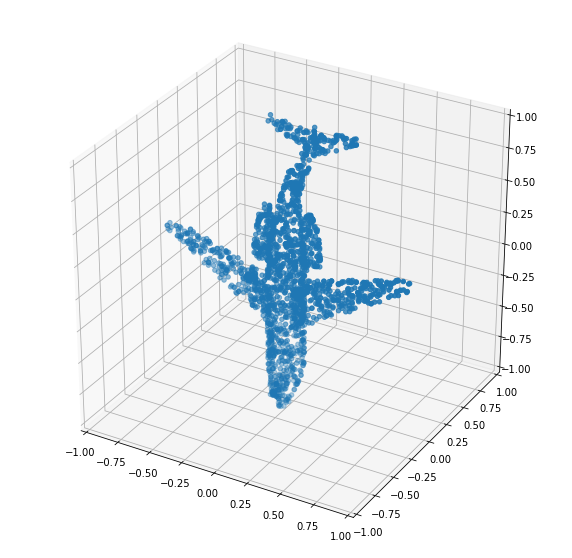

In [12]:
visualize(tr_pts)

In [13]:
# sigmas
if hasattr(cfg.trainer, "sigmas"):
    np_sigmas = cfg.trainer.sigmas
else:
    sigma_begin = float(cfg.trainer.sigma_begin)
    sigma_end = float(cfg.trainer.sigma_end)
    num_classes = int(cfg.trainer.sigma_num)
    np_sigmas = np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))
print("Sigma:, ", np_sigmas)
sigmas = torch.tensor(np.array(np_sigmas)).float().to(device).view(-1, 1)

Sigma:,  [0.5        0.44044226 0.38797877 0.34176449 0.30105505 0.26519474
 0.23360594 0.20577986 0.18126829 0.15967643 0.1406565  0.12390213
 0.10914347 0.09614279 0.0846907  0.07460273 0.06571639 0.05788855
 0.05099313 0.04491906 0.0395685  0.03485528 0.03070348 0.02704622
 0.02382459 0.02098672 0.01848687 0.0162848  0.01434503 0.01263631
 0.01113113 0.00980524 0.00863729 0.00760845 0.00670217 0.00590384
 0.0052006  0.00458113 0.00403544 0.00355476 0.00313133 0.00275834
 0.00242978 0.00214036 0.00188541 0.00166083 0.001463   0.00128873
 0.00113522 0.001     ]


In [ ]:
# def apply_spectral_norm(module):
#     norm = nn.BatchNorm1d
#     if not isinstance(module, norm) and 'weight' in module._parameters:
#         spectral_norm(module)

## Both SmallMLP

In [19]:
# score net
#score_net = Scorenet()
score_net = SmallMLP(in_dim=3, hidden_dim=512)
#critic_net = Criticnet()
critic_net = SmallMLP(in_dim=3, hidden_dim=512)

#critic_net.apply(apply_spectral_norm)
critic_net.to(device)
score_net.to(device)

print(score_net)
print(critic_net)

# optimizer
opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

SmallMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): Swish()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Swish()
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)
SmallMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): Swish()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Swish()
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)


## Just SmallMLP CriticNet

In [17]:
critic_net = SmallMLP(in_dim=3)
score_net = Scorenet()
#critic_net = Criticnet()
#critic_net = SmallMLP(in_dim=3)

#critic_net.apply(apply_spectral_norm)
critic_net.to(device)
score_net.to(device)

print(score_net)
print(critic_net)

# optimizer
opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

Scorenet(
  (conv_p): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
  (blocks): ModuleList(
    (0): ResnetBlockConv1d(
      (bn_0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_c): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
      (actvn): ReLU()
    )
    (1): ResnetBlockConv1d(
      (bn_0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_c): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
      (actvn): ReLU()
    )
    (2): ResnetBlockConv1d(
      (bn_0): BatchN

In [ ]:
# training
start_epoch = 0
n_epochs = 30000
print("Start epoch: %d End epoch: %d" % (start_epoch, cfg.trainer.epochs))
k_iters = 20
e_iters = 1
batch_size = 10
# sigmas = sigmas[-1:]

losses = []
cnt = 0
for epoch in range(start_epoch, n_epochs):
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()
    
    sigmas_idx = torch.randint(0, len(sigmas), (batch_size,), device=tr_pts.device)
    used_sigmas = sigmas[sigmas_idx].float()
    perturbed_points = tr_pts + torch.randn_like(tr_pts) * used_sigmas[..., None]
    
    score_pred = score_net(perturbed_points, used_sigmas)
    critic_output = critic_net(perturbed_points, used_sigmas)
    
    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)
    
    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()
    losses.append(loss)
    
    cycle_iter = epoch % (k_iters + e_iters)
    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()
    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        print("Epoch (critic) %d Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2))
    else:
        loss.backward()
        opt_scorenet.step()
        print("Epoch (score) %d Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2))
#     if epoch > 6000:
#         k_iters = 40
#         e_iters = 1
#     if epoch > 10000:
#         k_iters = 50
#         e_iters = 1

Start epoch: 0 End epoch: 100
Epoch (critic) 0 Loss=0.03381 t1=-0.00076 t2=0.03457
Epoch (critic) 1 Loss=0.75371 t1=-0.00158 t2=0.75529
Epoch (critic) 2 Loss=1.48253 t1=-0.00226 t2=1.48479
Epoch (critic) 3 Loss=2.23821 t1=-0.00327 t2=2.24148
Epoch (critic) 4 Loss=3.03177 t1=-0.00411 t2=3.03588
Epoch (critic) 5 Loss=3.87452 t1=-0.00516 t2=3.87968
Epoch (critic) 6 Loss=4.77843 t1=-0.00638 t2=4.78481
Epoch (critic) 7 Loss=5.74005 t1=-0.00712 t2=5.74717
Epoch (critic) 8 Loss=6.77052 t1=-0.00828 t2=6.77880
Epoch (critic) 9 Loss=7.86340 t1=-0.00869 t2=7.87209
Epoch (critic) 10 Loss=9.01485 t1=-0.00973 t2=9.02458
Epoch (critic) 11 Loss=10.21137 t1=-0.00905 t2=10.22041
Epoch (critic) 12 Loss=11.45679 t1=-0.01025 t2=11.46704
Epoch (critic) 13 Loss=12.75163 t1=-0.00974 t2=12.76136
Epoch (critic) 14 Loss=14.10943 t1=-0.00868 t2=14.11812
Epoch (critic) 15 Loss=15.49144 t1=-0.00445 t2=15.49589
Epoch (critic) 16 Loss=16.74422 t1=-0.00261 t2=16.74682
Epoch (critic) 17 Loss=17.84612 t1=-0.00542 t2=17.

Epoch (critic) 147 Loss=60.72584 t1=-1.92768 t2=62.65353
Epoch (critic) 148 Loss=50.92217 t1=-2.26805 t2=53.19022
Epoch (critic) 149 Loss=56.53994 t1=-2.13943 t2=58.67937
Epoch (critic) 150 Loss=54.53856 t1=-2.12900 t2=56.66755
Epoch (critic) 151 Loss=62.82962 t1=-2.07267 t2=64.90230
Epoch (critic) 152 Loss=53.29241 t1=-2.24311 t2=55.53551
Epoch (critic) 153 Loss=69.26028 t1=-2.03635 t2=71.29662
Epoch (critic) 154 Loss=62.67054 t1=-2.31831 t2=64.98886
Epoch (critic) 155 Loss=62.47513 t1=-2.37357 t2=64.84870
Epoch (critic) 156 Loss=55.18842 t1=-2.56204 t2=57.75046
Epoch (critic) 157 Loss=50.81566 t1=-2.74059 t2=53.55625
Epoch (critic) 158 Loss=67.23865 t1=-2.18853 t2=69.42718
Epoch (critic) 159 Loss=55.11013 t1=-2.41109 t2=57.52123
Epoch (critic) 160 Loss=59.32460 t1=-2.12194 t2=61.44653
Epoch (critic) 161 Loss=64.27583 t1=-2.05404 t2=66.32986
Epoch (critic) 162 Loss=55.87539 t1=-2.11390 t2=57.98928
Epoch (critic) 163 Loss=67.76137 t1=-1.85311 t2=69.61448
Epoch (critic) 164 Loss=57.5607

Epoch (critic) 291 Loss=121.82449 t1=-3.65171 t2=125.47620
Epoch (critic) 292 Loss=120.48846 t1=-3.86406 t2=124.35252
Epoch (score) 293 Loss=110.87913 t1=-3.50958 t2=114.38869
Epoch (critic) 294 Loss=92.95589 t1=-3.77778 t2=96.73368
Epoch (critic) 295 Loss=95.14898 t1=-3.83634 t2=98.98531
Epoch (critic) 296 Loss=115.68845 t1=-4.03748 t2=119.72593
Epoch (critic) 297 Loss=82.17641 t1=-3.24726 t2=85.42368
Epoch (critic) 298 Loss=81.43431 t1=-3.79831 t2=85.23261
Epoch (critic) 299 Loss=96.19210 t1=-3.92366 t2=100.11575
Epoch (critic) 300 Loss=115.03532 t1=-4.05666 t2=119.09197
Epoch (critic) 301 Loss=105.32555 t1=-3.73892 t2=109.06447
Epoch (critic) 302 Loss=129.11086 t1=-3.98102 t2=133.09187
Epoch (critic) 303 Loss=104.43943 t1=-3.94320 t2=108.38263
Epoch (critic) 304 Loss=101.76827 t1=-4.13969 t2=105.90796
Epoch (critic) 305 Loss=115.44799 t1=-4.35953 t2=119.80753
Epoch (critic) 306 Loss=83.42223 t1=-3.86694 t2=87.28918
Epoch (critic) 307 Loss=100.18677 t1=-3.77387 t2=103.96063
Epoch (cr

Epoch (critic) 433 Loss=95.04693 t1=-3.15698 t2=98.20391
Epoch (critic) 434 Loss=129.09679 t1=-4.13169 t2=133.22847
Epoch (critic) 435 Loss=120.80308 t1=-4.26029 t2=125.06335
Epoch (critic) 436 Loss=127.15520 t1=-4.41262 t2=131.56783
Epoch (critic) 437 Loss=115.40088 t1=-3.93022 t2=119.33109
Epoch (critic) 438 Loss=130.66428 t1=-3.43688 t2=134.10115
Epoch (critic) 439 Loss=134.75513 t1=-4.28096 t2=139.03610
Epoch (score) 440 Loss=95.77934 t1=-3.42359 t2=99.20293
Epoch (critic) 441 Loss=139.21632 t1=-5.69383 t2=144.91016
Epoch (critic) 442 Loss=93.37315 t1=-4.04944 t2=97.42260
Epoch (critic) 443 Loss=139.19167 t1=-4.82098 t2=144.01263
Epoch (critic) 444 Loss=95.71277 t1=-3.06707 t2=98.77984
Epoch (critic) 445 Loss=87.55297 t1=-2.30486 t2=89.85783
Epoch (critic) 446 Loss=109.41951 t1=-3.05283 t2=112.47234
Epoch (critic) 447 Loss=136.79845 t1=-4.30393 t2=141.10237
Epoch (critic) 448 Loss=134.12224 t1=-4.85113 t2=138.97337
Epoch (critic) 449 Loss=148.79564 t1=-5.19570 t2=153.99133
Epoch (c

Epoch (critic) 573 Loss=172.44290 t1=-5.96954 t2=178.41243
Epoch (critic) 574 Loss=209.85094 t1=-9.28288 t2=219.13379
Epoch (critic) 575 Loss=214.92159 t1=-5.64192 t2=220.56351
Epoch (critic) 576 Loss=116.15150 t1=2.08790 t2=114.06360
Epoch (critic) 577 Loss=108.83598 t1=-0.88593 t2=109.72190
Epoch (critic) 578 Loss=261.79523 t1=-8.69164 t2=270.48688
Epoch (critic) 579 Loss=120.64373 t1=1.87842 t2=118.76531
Epoch (critic) 580 Loss=196.18991 t1=-7.33894 t2=203.52885
Epoch (critic) 581 Loss=175.34644 t1=-6.57260 t2=181.91905
Epoch (critic) 582 Loss=159.50024 t1=0.31196 t2=159.18828
Epoch (critic) 583 Loss=134.63240 t1=-1.80628 t2=136.43867
Epoch (critic) 584 Loss=134.38554 t1=-1.01443 t2=135.39995
Epoch (critic) 585 Loss=178.47417 t1=-5.11071 t2=183.58488
Epoch (critic) 586 Loss=137.72191 t1=-2.40230 t2=140.12422
Epoch (score) 587 Loss=192.27977 t1=-2.86007 t2=195.13985
Epoch (critic) 588 Loss=219.20992 t1=-5.38138 t2=224.59129
Epoch (critic) 589 Loss=93.40362 t1=4.09755 t2=89.30605
Epoc

Epoch (score) 713 Loss=130.84317 t1=16.73493 t2=114.10824
Epoch (critic) 714 Loss=218.41380 t1=-1.69559 t2=220.10938
Epoch (critic) 715 Loss=281.82864 t1=1.43169 t2=280.39694
Epoch (critic) 716 Loss=230.28111 t1=-6.85641 t2=237.13750
Epoch (critic) 717 Loss=166.34062 t1=11.08904 t2=155.25159
Epoch (critic) 718 Loss=239.68433 t1=-5.05709 t2=244.74141
Epoch (critic) 719 Loss=237.78694 t1=9.96427 t2=227.82266
Epoch (critic) 720 Loss=245.34383 t1=-7.50336 t2=252.84721
Epoch (critic) 721 Loss=149.97873 t1=1.81314 t2=148.16559
Epoch (critic) 722 Loss=179.78223 t1=11.47033 t2=168.31192
Epoch (critic) 723 Loss=259.57883 t1=-11.45014 t2=271.02902
Epoch (critic) 724 Loss=209.34984 t1=-1.51077 t2=210.86063
Epoch (critic) 725 Loss=266.79684 t1=2.08510 t2=264.71176
Epoch (critic) 726 Loss=200.89742 t1=-6.03975 t2=206.93716
Epoch (critic) 727 Loss=289.49167 t1=-12.53170 t2=302.02341
Epoch (critic) 728 Loss=270.07217 t1=-7.43245 t2=277.50464
Epoch (critic) 729 Loss=256.54172 t1=-6.22719 t2=262.76892


Epoch (critic) 853 Loss=288.91333 t1=-6.00738 t2=294.92072
Epoch (critic) 854 Loss=333.92374 t1=-11.57092 t2=345.49466
Epoch (critic) 855 Loss=293.13776 t1=11.73057 t2=281.40714
Epoch (critic) 856 Loss=209.65811 t1=9.40509 t2=200.25301
Epoch (critic) 857 Loss=137.84477 t1=52.86660 t2=84.97818
Epoch (critic) 858 Loss=305.95163 t1=-14.22956 t2=320.18115
Epoch (critic) 859 Loss=195.93205 t1=-0.23433 t2=196.16638
Epoch (score) 860 Loss=224.87198 t1=-4.19254 t2=229.06456
Epoch (critic) 861 Loss=311.77438 t1=-11.79542 t2=323.56979
Epoch (critic) 862 Loss=310.82077 t1=-7.82839 t2=318.64914
Epoch (critic) 863 Loss=374.19177 t1=-14.42803 t2=388.61978
Epoch (critic) 864 Loss=230.02237 t1=-8.97139 t2=238.99376
Epoch (critic) 865 Loss=258.76074 t1=0.45354 t2=258.30722
Epoch (critic) 866 Loss=366.45883 t1=-13.95064 t2=380.40948
Epoch (critic) 867 Loss=248.91707 t1=3.55958 t2=245.35753
Epoch (critic) 868 Loss=304.13681 t1=-13.96446 t2=318.10126
Epoch (critic) 869 Loss=106.82185 t1=23.62099 t2=83.200

Epoch (critic) 993 Loss=288.74658 t1=-3.40250 t2=292.14908
Epoch (critic) 994 Loss=256.32330 t1=-9.14738 t2=265.47067
Epoch (critic) 995 Loss=345.98679 t1=15.08041 t2=330.90640
Epoch (critic) 996 Loss=392.82285 t1=-10.78779 t2=403.61063
Epoch (critic) 997 Loss=348.48160 t1=3.22087 t2=345.26071
Epoch (critic) 998 Loss=353.06790 t1=-1.93294 t2=355.00082
Epoch (critic) 999 Loss=279.43570 t1=11.64082 t2=267.79489
Epoch (critic) 1000 Loss=396.29575 t1=-9.06874 t2=405.36447
Epoch (critic) 1001 Loss=379.04288 t1=7.50468 t2=371.53824
Epoch (critic) 1002 Loss=342.35965 t1=-10.77492 t2=353.13458
Epoch (critic) 1003 Loss=320.86447 t1=28.32033 t2=292.54416
Epoch (critic) 1004 Loss=280.65796 t1=-4.44057 t2=285.09854
Epoch (critic) 1005 Loss=380.72223 t1=26.49425 t2=354.22797
Epoch (critic) 1006 Loss=386.67401 t1=0.85974 t2=385.81427
Epoch (score) 1007 Loss=379.22256 t1=8.20137 t2=371.02121
Epoch (critic) 1008 Loss=248.29202 t1=12.43834 t2=235.85367
Epoch (critic) 1009 Loss=287.58356 t1=-1.92207 t2=

Epoch (critic) 1131 Loss=478.40353 t1=-14.20451 t2=492.60800
Epoch (critic) 1132 Loss=499.39639 t1=3.98366 t2=495.41269
Epoch (score) 1133 Loss=388.17761 t1=7.78642 t2=380.39120
Epoch (critic) 1134 Loss=392.40994 t1=0.93815 t2=391.47177
Epoch (critic) 1135 Loss=443.33371 t1=-12.15081 t2=455.48447
Epoch (critic) 1136 Loss=223.96953 t1=14.23389 t2=209.73564
Epoch (critic) 1137 Loss=346.45532 t1=0.34383 t2=346.11151
Epoch (critic) 1138 Loss=361.23514 t1=-7.59081 t2=368.82593
Epoch (critic) 1139 Loss=407.27042 t1=-8.05489 t2=415.32529
Epoch (critic) 1140 Loss=333.60172 t1=1.23886 t2=332.36285
Epoch (critic) 1141 Loss=297.76236 t1=-5.50411 t2=303.26645
Epoch (critic) 1142 Loss=354.68539 t1=-9.85276 t2=364.53815
Epoch (critic) 1143 Loss=396.46265 t1=6.80370 t2=389.65894
Epoch (critic) 1144 Loss=401.30710 t1=-4.43576 t2=405.74283
Epoch (critic) 1145 Loss=513.87128 t1=-14.00861 t2=527.87988
Epoch (critic) 1146 Loss=250.43050 t1=13.98067 t2=236.44981
Epoch (critic) 1147 Loss=308.96506 t1=1.1925

Epoch (critic) 1269 Loss=355.28363 t1=-0.71303 t2=355.99664
Epoch (critic) 1270 Loss=525.70447 t1=-4.60477 t2=530.30914
Epoch (critic) 1271 Loss=335.38495 t1=1.03858 t2=334.34637
Epoch (critic) 1272 Loss=546.84686 t1=3.86292 t2=542.98401
Epoch (critic) 1273 Loss=353.79147 t1=-4.52922 t2=358.32068
Epoch (critic) 1274 Loss=296.71194 t1=12.02950 t2=284.68246
Epoch (critic) 1275 Loss=445.67300 t1=3.34373 t2=442.32925
Epoch (critic) 1276 Loss=392.70135 t1=-5.08780 t2=397.78912
Epoch (critic) 1277 Loss=429.07797 t1=-13.41988 t2=442.49786
Epoch (critic) 1278 Loss=409.93146 t1=-3.69284 t2=413.62433
Epoch (critic) 1279 Loss=467.80136 t1=-16.17975 t2=483.98117
Epoch (score) 1280 Loss=429.81894 t1=7.38500 t2=422.43393
Epoch (critic) 1281 Loss=472.82910 t1=-18.02193 t2=490.85104
Epoch (critic) 1282 Loss=373.25568 t1=-0.22502 t2=373.48068
Epoch (critic) 1283 Loss=500.70676 t1=-3.89695 t2=504.60373
Epoch (critic) 1284 Loss=375.61179 t1=25.86368 t2=349.74811
Epoch (critic) 1285 Loss=216.96489 t1=47.7

Epoch (critic) 1407 Loss=564.34698 t1=-11.79485 t2=576.14185
Epoch (critic) 1408 Loss=451.26071 t1=5.70910 t2=445.55157
Epoch (critic) 1409 Loss=415.08942 t1=-11.12232 t2=426.21173
Epoch (critic) 1410 Loss=416.37500 t1=19.06530 t2=397.30966
Epoch (critic) 1411 Loss=563.23212 t1=-15.71909 t2=578.95129
Epoch (critic) 1412 Loss=650.52667 t1=13.38896 t2=637.13770
Epoch (critic) 1413 Loss=519.83496 t1=2.76544 t2=517.06946
Epoch (critic) 1414 Loss=291.31064 t1=-8.96132 t2=300.27194
Epoch (critic) 1415 Loss=234.73619 t1=32.47938 t2=202.25679
Epoch (critic) 1416 Loss=380.11102 t1=5.65559 t2=374.45541
Epoch (critic) 1417 Loss=200.92577 t1=10.59138 t2=190.33438
Epoch (critic) 1418 Loss=547.27618 t1=-15.63164 t2=562.90784
Epoch (critic) 1419 Loss=277.91284 t1=2.36068 t2=275.55215
Epoch (critic) 1420 Loss=484.10065 t1=6.17110 t2=477.92950
Epoch (critic) 1421 Loss=415.86652 t1=7.55276 t2=408.31372
Epoch (critic) 1422 Loss=389.30356 t1=11.44776 t2=377.85577
Epoch (critic) 1423 Loss=493.77750 t1=-2.9

Epoch (critic) 1545 Loss=496.27246 t1=13.48363 t2=482.78888
Epoch (critic) 1546 Loss=685.24396 t1=11.54140 t2=673.70258
Epoch (critic) 1547 Loss=449.44922 t1=-10.38802 t2=459.83722
Epoch (critic) 1548 Loss=336.08569 t1=6.27751 t2=329.80820
Epoch (critic) 1549 Loss=380.48386 t1=-3.78244 t2=384.26630
Epoch (critic) 1550 Loss=658.61993 t1=-21.32082 t2=679.94073
Epoch (critic) 1551 Loss=699.07581 t1=-10.12653 t2=709.20233
Epoch (critic) 1552 Loss=330.10019 t1=-4.21990 t2=334.32007
Epoch (score) 1553 Loss=304.83969 t1=38.96745 t2=265.87228
Epoch (critic) 1554 Loss=334.51382 t1=9.44274 t2=325.07108
Epoch (critic) 1555 Loss=558.07343 t1=9.37474 t2=548.69873
Epoch (critic) 1556 Loss=490.36426 t1=22.80365 t2=467.56061
Epoch (critic) 1557 Loss=485.85056 t1=18.84350 t2=467.00705
Epoch (critic) 1558 Loss=532.12543 t1=10.99715 t2=521.12823
Epoch (critic) 1559 Loss=526.84906 t1=21.12009 t2=505.72897
Epoch (critic) 1560 Loss=476.42218 t1=-16.96290 t2=493.38510
Epoch (critic) 1561 Loss=338.65549 t1=21

Epoch (critic) 1683 Loss=498.43350 t1=26.85431 t2=471.57916
Epoch (critic) 1684 Loss=387.74738 t1=3.07116 t2=384.67624
Epoch (critic) 1685 Loss=558.56952 t1=-1.08863 t2=559.65820
Epoch (critic) 1686 Loss=507.21198 t1=-1.00138 t2=508.21338
Epoch (critic) 1687 Loss=676.76282 t1=-3.19666 t2=679.95947
Epoch (critic) 1688 Loss=454.79962 t1=18.81164 t2=435.98801
Epoch (critic) 1689 Loss=555.75165 t1=-6.12625 t2=561.87787
Epoch (critic) 1690 Loss=437.84244 t1=16.55308 t2=421.28937
Epoch (critic) 1691 Loss=574.60431 t1=5.64783 t2=568.95648
Epoch (critic) 1692 Loss=399.53647 t1=-9.14419 t2=408.68069
Epoch (critic) 1693 Loss=749.53528 t1=-3.69786 t2=753.23309
Epoch (critic) 1694 Loss=426.86270 t1=-2.29792 t2=429.16064
Epoch (critic) 1695 Loss=573.58130 t1=5.16733 t2=568.41400
Epoch (critic) 1696 Loss=534.15869 t1=0.97695 t2=533.18176
Epoch (critic) 1697 Loss=667.25018 t1=-19.75473 t2=687.00488
Epoch (critic) 1698 Loss=753.79681 t1=-22.01034 t2=775.80713
Epoch (critic) 1699 Loss=533.39441 t1=-9.1

Epoch (critic) 1821 Loss=516.88916 t1=6.95678 t2=509.93237
Epoch (critic) 1822 Loss=415.50168 t1=11.34855 t2=404.15314
Epoch (critic) 1823 Loss=666.79980 t1=5.51055 t2=661.28925
Epoch (critic) 1824 Loss=705.27454 t1=-16.21814 t2=721.49268
Epoch (critic) 1825 Loss=668.83032 t1=-17.32077 t2=686.15106
Epoch (score) 1826 Loss=497.87100 t1=-1.30234 t2=499.17334
Epoch (critic) 1827 Loss=520.07080 t1=-0.11075 t2=520.18158
Epoch (critic) 1828 Loss=463.40341 t1=0.32875 t2=463.07468
Epoch (critic) 1829 Loss=731.90137 t1=-21.16479 t2=753.06616
Epoch (critic) 1830 Loss=645.02698 t1=-5.71520 t2=650.74219
Epoch (critic) 1831 Loss=655.23529 t1=-10.39625 t2=665.63147
Epoch (critic) 1832 Loss=460.96182 t1=-4.89348 t2=465.85532
Epoch (critic) 1833 Loss=722.23096 t1=17.08354 t2=705.14746
Epoch (critic) 1834 Loss=254.45918 t1=38.19823 t2=216.26094
Epoch (critic) 1835 Loss=333.65341 t1=2.01429 t2=331.63913
Epoch (critic) 1836 Loss=319.55283 t1=15.74149 t2=303.81134
Epoch (critic) 1837 Loss=707.99670 t1=2.4

Epoch (critic) 1959 Loss=478.57944 t1=3.01692 t2=475.56256
Epoch (critic) 1960 Loss=465.35733 t1=-6.88535 t2=472.24268
Epoch (critic) 1961 Loss=953.79474 t1=-14.07233 t2=967.86700
Epoch (critic) 1962 Loss=583.20605 t1=4.35886 t2=578.84717
Epoch (critic) 1963 Loss=535.18060 t1=-8.39773 t2=543.57831
Epoch (critic) 1964 Loss=556.56732 t1=-15.13967 t2=571.70697
Epoch (critic) 1965 Loss=542.01459 t1=10.26608 t2=531.74847
Epoch (critic) 1966 Loss=657.25043 t1=-1.66949 t2=658.91986
Epoch (critic) 1967 Loss=570.23230 t1=-13.76683 t2=583.99915
Epoch (critic) 1968 Loss=821.26495 t1=-10.03210 t2=831.29706
Epoch (critic) 1969 Loss=360.40439 t1=20.08910 t2=340.31528
Epoch (critic) 1970 Loss=1121.74817 t1=-22.86711 t2=1144.61523
Epoch (critic) 1971 Loss=576.51746 t1=-4.76242 t2=581.27991
Epoch (critic) 1972 Loss=414.39291 t1=-10.00112 t2=424.39404
Epoch (score) 1973 Loss=897.86932 t1=-24.85640 t2=922.72577
Epoch (critic) 1974 Loss=772.49249 t1=19.38298 t2=753.10956
Epoch (critic) 1975 Loss=674.90369

Epoch (critic) 2097 Loss=580.52686 t1=10.96164 t2=569.56519
Epoch (critic) 2098 Loss=632.47089 t1=1.59622 t2=630.87469
Epoch (score) 2099 Loss=719.26849 t1=-8.04563 t2=727.31409
Epoch (critic) 2100 Loss=642.16608 t1=-3.62703 t2=645.79309
Epoch (critic) 2101 Loss=534.11542 t1=10.98244 t2=523.13300
Epoch (critic) 2102 Loss=686.58600 t1=-15.11094 t2=701.69696
Epoch (critic) 2103 Loss=505.29395 t1=19.22084 t2=486.07309
Epoch (critic) 2104 Loss=421.35202 t1=-3.36303 t2=424.71500
Epoch (critic) 2105 Loss=682.66931 t1=-14.02608 t2=696.69537
Epoch (critic) 2106 Loss=480.30371 t1=18.42598 t2=461.87769
Epoch (critic) 2107 Loss=780.45337 t1=-21.49585 t2=801.94922
Epoch (critic) 2108 Loss=522.06879 t1=-11.22817 t2=533.29700
Epoch (critic) 2109 Loss=591.00702 t1=-3.74413 t2=594.75116
Epoch (critic) 2110 Loss=739.21252 t1=-8.25386 t2=747.46643
Epoch (critic) 2111 Loss=641.36176 t1=1.01182 t2=640.34985
Epoch (critic) 2112 Loss=479.02759 t1=-6.45450 t2=485.48209
Epoch (critic) 2113 Loss=706.95868 t1=2

Epoch (critic) 2235 Loss=517.62061 t1=7.69133 t2=509.92929
Epoch (critic) 2236 Loss=352.87314 t1=7.28746 t2=345.58569
Epoch (critic) 2237 Loss=333.21539 t1=2.37475 t2=330.84064
Epoch (critic) 2238 Loss=631.37451 t1=9.83029 t2=621.54431
Epoch (critic) 2239 Loss=704.17084 t1=-8.77562 t2=712.94641
Epoch (critic) 2240 Loss=470.49210 t1=-12.34624 t2=482.83838
Epoch (critic) 2241 Loss=850.87885 t1=-14.57085 t2=865.44965
Epoch (critic) 2242 Loss=613.37909 t1=25.60365 t2=587.77551
Epoch (critic) 2243 Loss=788.63873 t1=6.24417 t2=782.39459
Epoch (critic) 2244 Loss=353.41245 t1=24.35404 t2=329.05841
Epoch (critic) 2245 Loss=656.00696 t1=30.66903 t2=625.33789
Epoch (score) 2246 Loss=546.75946 t1=6.98127 t2=539.77820
Epoch (critic) 2247 Loss=505.92529 t1=-4.14392 t2=510.06924
Epoch (critic) 2248 Loss=878.46271 t1=-19.36637 t2=897.82910
Epoch (critic) 2249 Loss=949.29608 t1=-9.78772 t2=959.08380
Epoch (critic) 2250 Loss=426.68399 t1=-11.04278 t2=437.72678
Epoch (critic) 2251 Loss=916.79816 t1=-7.59

Epoch (critic) 2371 Loss=314.83334 t1=33.27934 t2=281.55402
Epoch (score) 2372 Loss=588.28680 t1=13.04030 t2=575.24652
Epoch (critic) 2373 Loss=361.51495 t1=-1.65954 t2=363.17450
Epoch (critic) 2374 Loss=761.40314 t1=-17.07864 t2=778.48175
Epoch (critic) 2375 Loss=1087.16028 t1=-28.94850 t2=1116.10876
Epoch (critic) 2376 Loss=568.26447 t1=6.18240 t2=562.08209
Epoch (critic) 2377 Loss=976.91370 t1=-20.14579 t2=997.05951
Epoch (critic) 2378 Loss=426.55908 t1=-11.06426 t2=437.62335
Epoch (critic) 2379 Loss=666.18945 t1=1.02962 t2=665.15985
Epoch (critic) 2380 Loss=442.95187 t1=10.17051 t2=432.78134
Epoch (critic) 2381 Loss=961.10547 t1=-8.10240 t2=969.20782
Epoch (critic) 2382 Loss=950.14813 t1=1.86311 t2=948.28516
Epoch (critic) 2383 Loss=417.19244 t1=0.48048 t2=416.71191
Epoch (critic) 2384 Loss=871.33594 t1=-21.36356 t2=892.69952
Epoch (critic) 2385 Loss=997.20197 t1=-21.81392 t2=1019.01581
Epoch (critic) 2386 Loss=799.25006 t1=5.06870 t2=794.18134
Epoch (critic) 2387 Loss=931.02051 t1

Epoch (critic) 2507 Loss=698.56488 t1=-10.42049 t2=708.98529
Epoch (critic) 2508 Loss=923.50238 t1=-9.00568 t2=932.50800
Epoch (critic) 2509 Loss=1072.12720 t1=-7.24790 t2=1079.37512
Epoch (critic) 2510 Loss=739.42065 t1=35.90666 t2=703.51404
Epoch (critic) 2511 Loss=1073.91016 t1=-14.21846 t2=1088.12854
Epoch (critic) 2512 Loss=875.61182 t1=-2.61622 t2=878.22803
Epoch (critic) 2513 Loss=734.23724 t1=1.99488 t2=732.24237
Epoch (critic) 2514 Loss=871.83441 t1=-1.78128 t2=873.61566
Epoch (critic) 2515 Loss=1285.78149 t1=-18.39799 t2=1304.17957
Epoch (critic) 2516 Loss=711.57471 t1=-15.62736 t2=727.20209
Epoch (critic) 2517 Loss=324.46832 t1=-1.88828 t2=326.35657
Epoch (critic) 2518 Loss=883.80389 t1=-9.96276 t2=893.76678
Epoch (score) 2519 Loss=985.49805 t1=-19.88622 t2=1005.38428
Epoch (critic) 2520 Loss=735.24835 t1=16.39422 t2=718.85413
Epoch (critic) 2521 Loss=566.64905 t1=12.35877 t2=554.29022
Epoch (critic) 2522 Loss=509.29941 t1=-18.70274 t2=528.00214
Epoch (critic) 2523 Loss=988.

Epoch (critic) 2643 Loss=373.48825 t1=3.64113 t2=369.84711
Epoch (critic) 2644 Loss=345.74777 t1=10.61128 t2=335.13647
Epoch (score) 2645 Loss=817.57855 t1=-1.21971 t2=818.79828
Epoch (critic) 2646 Loss=632.99939 t1=14.75817 t2=618.24121
Epoch (critic) 2647 Loss=347.54465 t1=25.61863 t2=321.92603
Epoch (critic) 2648 Loss=1042.60474 t1=-26.97564 t2=1069.58044
Epoch (critic) 2649 Loss=836.95850 t1=7.42779 t2=829.53076
Epoch (critic) 2650 Loss=400.00388 t1=-7.49490 t2=407.49878
Epoch (critic) 2651 Loss=567.86407 t1=27.15368 t2=540.71039
Epoch (critic) 2652 Loss=990.31836 t1=-7.75077 t2=998.06915
Epoch (critic) 2653 Loss=545.86908 t1=5.46910 t2=540.40002
Epoch (critic) 2654 Loss=1122.09875 t1=-6.28764 t2=1128.38635
Epoch (critic) 2655 Loss=786.26044 t1=26.28634 t2=759.97412
Epoch (critic) 2656 Loss=713.99524 t1=9.65134 t2=704.34393
Epoch (critic) 2657 Loss=415.91220 t1=31.16752 t2=384.74469
Epoch (critic) 2658 Loss=839.49628 t1=-14.25304 t2=853.74933
Epoch (critic) 2659 Loss=544.60712 t1=4

Epoch (critic) 2779 Loss=758.25720 t1=-13.88170 t2=772.13892
Epoch (critic) 2780 Loss=435.41241 t1=24.20677 t2=411.20563
Epoch (critic) 2781 Loss=823.47327 t1=-12.72625 t2=836.19940
Epoch (critic) 2782 Loss=1184.15417 t1=-13.15864 t2=1197.31274
Epoch (critic) 2783 Loss=647.12421 t1=-0.31979 t2=647.44403
Epoch (critic) 2784 Loss=935.48187 t1=-23.41291 t2=958.89471
Epoch (critic) 2785 Loss=581.67871 t1=-2.63455 t2=584.31329
Epoch (critic) 2786 Loss=680.79211 t1=-17.15227 t2=697.94440
Epoch (critic) 2787 Loss=1217.50757 t1=-26.10774 t2=1243.61523
Epoch (critic) 2788 Loss=502.40210 t1=0.52213 t2=501.87997
Epoch (critic) 2789 Loss=895.35077 t1=-2.57258 t2=897.92334
Epoch (critic) 2790 Loss=735.04657 t1=10.92169 t2=724.12482
Epoch (critic) 2791 Loss=518.14569 t1=21.25975 t2=496.88589
Epoch (score) 2792 Loss=655.23309 t1=-9.39823 t2=664.63135
Epoch (critic) 2793 Loss=478.82965 t1=2.96570 t2=475.86398
Epoch (critic) 2794 Loss=675.59082 t1=-3.88142 t2=679.47229
Epoch (critic) 2795 Loss=1004.947

Epoch (critic) 2915 Loss=466.81241 t1=0.17120 t2=466.64127
Epoch (critic) 2916 Loss=483.86163 t1=0.22642 t2=483.63525
Epoch (critic) 2917 Loss=901.73047 t1=-25.65302 t2=927.38342
Epoch (score) 2918 Loss=935.87225 t1=-18.49313 t2=954.36536
Epoch (critic) 2919 Loss=957.43860 t1=-19.18784 t2=976.62640
Epoch (critic) 2920 Loss=1164.94324 t1=-12.67293 t2=1177.61621
Epoch (critic) 2921 Loss=993.68164 t1=-2.62759 t2=996.30920
Epoch (critic) 2922 Loss=393.80710 t1=36.57955 t2=357.22751
Epoch (critic) 2923 Loss=651.95233 t1=32.71024 t2=619.24213
Epoch (critic) 2924 Loss=443.56232 t1=-9.77740 t2=453.33966
Epoch (critic) 2925 Loss=911.13684 t1=-1.94971 t2=913.08655
Epoch (critic) 2926 Loss=1014.71613 t1=-17.29788 t2=1032.01392
Epoch (critic) 2927 Loss=913.02979 t1=-12.34931 t2=925.37909
Epoch (critic) 2928 Loss=862.81805 t1=-18.65711 t2=881.47522
Epoch (critic) 2929 Loss=709.55029 t1=-6.75642 t2=716.30676
Epoch (critic) 2930 Loss=1028.83044 t1=-6.94086 t2=1035.77136
Epoch (critic) 2931 Loss=1117.

Epoch (critic) 3051 Loss=797.24286 t1=-12.65551 t2=809.89844
Epoch (critic) 3052 Loss=1643.35547 t1=-38.98246 t2=1682.33813
Epoch (critic) 3053 Loss=769.70471 t1=7.20297 t2=762.50165
Epoch (critic) 3054 Loss=914.00647 t1=-14.10934 t2=928.11584
Epoch (critic) 3055 Loss=517.92157 t1=28.73315 t2=489.18839
Epoch (critic) 3056 Loss=1425.41919 t1=-3.90749 t2=1429.32654
Epoch (critic) 3057 Loss=1155.24670 t1=-4.61981 t2=1159.86646
Epoch (critic) 3058 Loss=1160.45056 t1=-13.96140 t2=1174.41199
Epoch (critic) 3059 Loss=701.89893 t1=28.66466 t2=673.23431
Epoch (critic) 3060 Loss=946.90057 t1=-14.44394 t2=961.34467
Epoch (critic) 3061 Loss=707.05847 t1=7.35250 t2=699.70599
Epoch (critic) 3062 Loss=707.89447 t1=4.93975 t2=702.95465
Epoch (critic) 3063 Loss=752.85956 t1=13.21599 t2=739.64355
Epoch (critic) 3064 Loss=719.90442 t1=22.33953 t2=697.56488
Epoch (score) 3065 Loss=843.57422 t1=2.56723 t2=841.00702
Epoch (critic) 3066 Loss=1207.32642 t1=-18.25995 t2=1225.58630
Epoch (critic) 3067 Loss=611.

Epoch (critic) 3187 Loss=356.85092 t1=-2.65579 t2=359.50668
Epoch (critic) 3188 Loss=937.02924 t1=-4.35153 t2=941.38068
Epoch (critic) 3189 Loss=779.70428 t1=3.20220 t2=776.50214
Epoch (critic) 3190 Loss=1224.03711 t1=14.25323 t2=1209.78394
Epoch (score) 3191 Loss=854.60352 t1=2.84546 t2=851.75812
Epoch (critic) 3192 Loss=1134.34082 t1=-0.33980 t2=1134.68066
Epoch (critic) 3193 Loss=1184.25916 t1=-9.62270 t2=1193.88184
Epoch (critic) 3194 Loss=995.30487 t1=-2.93148 t2=998.23651
Epoch (critic) 3195 Loss=1532.81750 t1=-14.80721 t2=1547.62476
Epoch (critic) 3196 Loss=613.85541 t1=7.07312 t2=606.78223
Epoch (critic) 3197 Loss=901.14886 t1=-2.17329 t2=903.32220
Epoch (critic) 3198 Loss=614.46613 t1=-10.59714 t2=625.06329
Epoch (critic) 3199 Loss=920.58978 t1=6.62849 t2=913.96136
Epoch (critic) 3200 Loss=1086.05139 t1=-23.03465 t2=1109.08594
Epoch (critic) 3201 Loss=1217.11096 t1=-5.91181 t2=1223.02271
Epoch (critic) 3202 Loss=1092.18738 t1=-1.82750 t2=1094.01477
Epoch (critic) 3203 Loss=606

Epoch (critic) 3323 Loss=797.49268 t1=-7.68065 t2=805.17334
Epoch (critic) 3324 Loss=886.04022 t1=10.09026 t2=875.95001
Epoch (critic) 3325 Loss=753.23383 t1=1.83171 t2=751.40216
Epoch (critic) 3326 Loss=843.82208 t1=0.86795 t2=842.95410
Epoch (critic) 3327 Loss=900.29767 t1=-4.06192 t2=904.35956
Epoch (critic) 3328 Loss=1057.25232 t1=-5.50545 t2=1062.75781
Epoch (critic) 3329 Loss=1104.17700 t1=-16.87151 t2=1121.04846
Epoch (critic) 3330 Loss=941.88458 t1=-8.39252 t2=950.27716
Epoch (critic) 3331 Loss=1108.59167 t1=-13.93507 t2=1122.52673
Epoch (critic) 3332 Loss=1337.21814 t1=-13.51716 t2=1350.73523
Epoch (critic) 3333 Loss=976.28674 t1=-12.46303 t2=988.74969
Epoch (critic) 3334 Loss=618.52228 t1=8.65008 t2=609.87225
Epoch (critic) 3335 Loss=1085.52527 t1=-7.75307 t2=1093.27844
Epoch (critic) 3336 Loss=889.37158 t1=-5.77421 t2=895.14581
Epoch (critic) 3337 Loss=783.16333 t1=-12.62395 t2=795.78729
Epoch (score) 3338 Loss=584.40814 t1=-5.58613 t2=589.99426
Epoch (critic) 3339 Loss=1498

Epoch (critic) 3459 Loss=998.31427 t1=-25.56923 t2=1023.88342
Epoch (critic) 3460 Loss=967.89471 t1=6.74960 t2=961.14514
Epoch (critic) 3461 Loss=875.23383 t1=11.01571 t2=864.21820
Epoch (critic) 3462 Loss=998.28876 t1=-12.49494 t2=1010.78363
Epoch (critic) 3463 Loss=1138.41296 t1=-10.87678 t2=1149.28967
Epoch (score) 3464 Loss=990.88867 t1=-4.61546 t2=995.50409
Epoch (critic) 3465 Loss=725.79742 t1=14.22465 t2=711.57275
Epoch (critic) 3466 Loss=1095.71802 t1=20.12463 t2=1075.59351
Epoch (critic) 3467 Loss=881.02979 t1=-11.77077 t2=892.80060
Epoch (critic) 3468 Loss=1173.12366 t1=-20.00809 t2=1193.13171
Epoch (critic) 3469 Loss=824.17059 t1=-8.21022 t2=832.38086
Epoch (critic) 3470 Loss=823.15509 t1=-16.66859 t2=839.82367
Epoch (critic) 3471 Loss=1132.99084 t1=-8.10227 t2=1141.09314
Epoch (critic) 3472 Loss=774.80780 t1=14.43807 t2=760.36975
Epoch (critic) 3473 Loss=964.37970 t1=-8.48773 t2=972.86737
Epoch (critic) 3474 Loss=819.01782 t1=-3.30984 t2=822.32776
Epoch (critic) 3475 Loss=1

Epoch (critic) 3595 Loss=1221.89685 t1=-3.50666 t2=1225.40344
Epoch (critic) 3596 Loss=727.49219 t1=9.45027 t2=718.04193
Epoch (critic) 3597 Loss=1501.69788 t1=-33.85840 t2=1535.55627
Epoch (critic) 3598 Loss=1340.51489 t1=-28.06860 t2=1368.58337
Epoch (critic) 3599 Loss=848.31622 t1=3.96947 t2=844.34680
Epoch (critic) 3600 Loss=1059.30701 t1=-3.23015 t2=1062.53711
Epoch (critic) 3601 Loss=485.01471 t1=-1.26001 t2=486.27472
Epoch (critic) 3602 Loss=849.72626 t1=11.25957 t2=838.46674
Epoch (critic) 3603 Loss=848.24969 t1=-0.32890 t2=848.57861
Epoch (critic) 3604 Loss=1050.43152 t1=2.96043 t2=1047.47107
Epoch (critic) 3605 Loss=715.77216 t1=8.05639 t2=707.71582
Epoch (critic) 3606 Loss=965.23871 t1=-3.04009 t2=968.27875
Epoch (critic) 3607 Loss=793.25409 t1=-6.20206 t2=799.45618
Epoch (critic) 3608 Loss=1554.81213 t1=-24.39949 t2=1579.21155
Epoch (critic) 3609 Loss=989.72540 t1=19.68550 t2=970.04004
Epoch (critic) 3610 Loss=776.71948 t1=22.97384 t2=753.74567
Epoch (score) 3611 Loss=876.5

Epoch (critic) 3731 Loss=1019.37415 t1=-3.01016 t2=1022.38428
Epoch (critic) 3732 Loss=965.87567 t1=-1.41986 t2=967.29553
Epoch (critic) 3733 Loss=977.46350 t1=17.39362 t2=960.06995
Epoch (critic) 3734 Loss=671.79047 t1=-9.50473 t2=681.29523
Epoch (critic) 3735 Loss=1065.08740 t1=-6.87413 t2=1071.96155
Epoch (critic) 3736 Loss=836.74164 t1=-2.17077 t2=838.91229
Epoch (score) 3737 Loss=548.93414 t1=3.71099 t2=545.22314
Epoch (critic) 3738 Loss=1071.75818 t1=11.99797 t2=1059.76013
Epoch (critic) 3739 Loss=997.42365 t1=-14.30802 t2=1011.73163
Epoch (critic) 3740 Loss=1318.42957 t1=-10.96832 t2=1329.39783
Epoch (critic) 3741 Loss=1243.69202 t1=1.14890 t2=1242.54321
Epoch (critic) 3742 Loss=458.80688 t1=19.26214 t2=439.54474
Epoch (critic) 3743 Loss=1312.45020 t1=-6.34658 t2=1318.79688
Epoch (critic) 3744 Loss=701.78217 t1=15.13520 t2=686.64691
Epoch (critic) 3745 Loss=751.51093 t1=-10.89066 t2=762.40155
Epoch (critic) 3746 Loss=1162.76184 t1=-3.13068 t2=1165.89246
Epoch (critic) 3747 Loss=

Epoch (critic) 3867 Loss=1195.36084 t1=-8.97567 t2=1204.33655
Epoch (critic) 3868 Loss=1723.11560 t1=-29.01691 t2=1752.13245
Epoch (critic) 3869 Loss=903.37744 t1=11.32133 t2=892.05609
Epoch (critic) 3870 Loss=1482.59985 t1=10.72944 t2=1471.87036
Epoch (critic) 3871 Loss=518.46191 t1=8.24330 t2=510.21866
Epoch (critic) 3872 Loss=1020.75629 t1=9.94583 t2=1010.81049
Epoch (critic) 3873 Loss=448.80377 t1=26.70950 t2=422.09424
Epoch (critic) 3874 Loss=936.54883 t1=-0.15303 t2=936.70178
Epoch (critic) 3875 Loss=1337.60303 t1=-21.84475 t2=1359.44788
Epoch (critic) 3876 Loss=989.46252 t1=-15.01694 t2=1004.47943
Epoch (critic) 3877 Loss=799.83002 t1=-8.12043 t2=807.95044
Epoch (critic) 3878 Loss=832.29865 t1=3.12789 t2=829.17072
Epoch (critic) 3879 Loss=965.58984 t1=-9.55093 t2=975.14081
Epoch (critic) 3880 Loss=1183.07214 t1=-0.00305 t2=1183.07544
Epoch (critic) 3881 Loss=901.13885 t1=4.23042 t2=896.90839
Epoch (critic) 3882 Loss=544.62250 t1=14.91225 t2=529.71021
Epoch (critic) 3883 Loss=125

Epoch (critic) 4003 Loss=593.46429 t1=12.74401 t2=580.72021
Epoch (critic) 4004 Loss=1080.59827 t1=-2.11007 t2=1082.70825
Epoch (critic) 4005 Loss=1276.73474 t1=-2.10978 t2=1278.84460
Epoch (critic) 4006 Loss=1664.47876 t1=-11.02492 t2=1675.50354
Epoch (critic) 4007 Loss=485.87140 t1=17.67830 t2=468.19308
Epoch (critic) 4008 Loss=921.42871 t1=5.12197 t2=916.30664
Epoch (critic) 4009 Loss=803.59760 t1=21.63442 t2=781.96320
Epoch (score) 4010 Loss=938.54504 t1=0.46390 t2=938.08118
Epoch (critic) 4011 Loss=232.31982 t1=15.32384 t2=216.99597
Epoch (critic) 4012 Loss=866.45770 t1=-10.41687 t2=876.87463
Epoch (critic) 4013 Loss=2072.58667 t1=-51.63572 t2=2124.22241
Epoch (critic) 4014 Loss=608.65588 t1=-7.84981 t2=616.50568
Epoch (critic) 4015 Loss=1711.29773 t1=-25.61327 t2=1736.91101
Epoch (critic) 4016 Loss=1088.13574 t1=7.35396 t2=1080.78174
Epoch (critic) 4017 Loss=613.46979 t1=25.38571 t2=588.08411
Epoch (critic) 4018 Loss=929.11017 t1=-0.53360 t2=929.64374
Epoch (critic) 4019 Loss=149

Epoch (critic) 4139 Loss=648.28186 t1=-1.83083 t2=650.11267
Epoch (critic) 4140 Loss=950.73712 t1=-0.95446 t2=951.69141
Epoch (critic) 4141 Loss=1731.41589 t1=-25.63685 t2=1757.05273
Epoch (critic) 4142 Loss=1332.12988 t1=-17.87907 t2=1350.00903
Epoch (critic) 4143 Loss=1154.85828 t1=-14.23455 t2=1169.09302
Epoch (critic) 4144 Loss=699.17010 t1=0.57190 t2=698.59827
Epoch (critic) 4145 Loss=1646.00293 t1=-23.22220 t2=1669.22498
Epoch (critic) 4146 Loss=371.06677 t1=9.96337 t2=361.10342
Epoch (critic) 4147 Loss=937.88910 t1=7.66831 t2=930.22070
Epoch (critic) 4148 Loss=1559.76685 t1=-5.01707 t2=1564.78394
Epoch (critic) 4149 Loss=871.12854 t1=7.51838 t2=863.61005
Epoch (critic) 4150 Loss=583.34259 t1=-2.06779 t2=585.41034
Epoch (critic) 4151 Loss=1342.63708 t1=-12.20786 t2=1354.84497
Epoch (critic) 4152 Loss=1280.91992 t1=-17.60405 t2=1298.52393
Epoch (critic) 4153 Loss=1113.62976 t1=-13.14576 t2=1126.77539
Epoch (critic) 4154 Loss=1101.27722 t1=-13.68972 t2=1114.96704
Epoch (critic) 415

Epoch (critic) 4273 Loss=1227.27527 t1=-9.78660 t2=1237.06177
Epoch (critic) 4274 Loss=1055.73242 t1=-5.81209 t2=1061.54456
Epoch (critic) 4275 Loss=900.63068 t1=-3.62254 t2=904.25311
Epoch (critic) 4276 Loss=1355.51746 t1=-12.97061 t2=1368.48792
Epoch (critic) 4277 Loss=728.21838 t1=-18.96394 t2=747.18231
Epoch (critic) 4278 Loss=1465.82239 t1=-19.85110 t2=1485.67346
Epoch (critic) 4279 Loss=1114.41235 t1=-8.63653 t2=1123.04871
Epoch (critic) 4280 Loss=1252.27368 t1=-26.06384 t2=1278.33752
Epoch (critic) 4281 Loss=1684.26453 t1=-24.87315 t2=1709.13770
Epoch (critic) 4282 Loss=1614.58093 t1=-6.56683 t2=1621.14771
Epoch (score) 4283 Loss=1439.01941 t1=-7.43043 t2=1446.44983
Epoch (critic) 4284 Loss=1420.07556 t1=-20.80317 t2=1440.87878
Epoch (critic) 4285 Loss=1334.96008 t1=-0.52162 t2=1335.48181
Epoch (critic) 4286 Loss=1372.85693 t1=-13.82304 t2=1386.68005
Epoch (critic) 4287 Loss=567.54016 t1=-5.17895 t2=572.71906
Epoch (critic) 4288 Loss=1279.81311 t1=-7.93898 t2=1287.75208
Epoch (c

Epoch (critic) 4407 Loss=307.19101 t1=4.87322 t2=302.31778
Epoch (critic) 4408 Loss=1019.56512 t1=-11.03124 t2=1030.59644
Epoch (score) 4409 Loss=883.51385 t1=3.03362 t2=880.48029
Epoch (critic) 4410 Loss=374.10516 t1=-5.05819 t2=379.16339
Epoch (critic) 4411 Loss=366.31870 t1=10.21910 t2=356.09961
Epoch (critic) 4412 Loss=1088.27478 t1=-13.87776 t2=1102.15259
Epoch (critic) 4413 Loss=908.45081 t1=-10.19951 t2=918.65021
Epoch (critic) 4414 Loss=871.06073 t1=5.87492 t2=865.18585
Epoch (critic) 4415 Loss=995.22021 t1=-12.03147 t2=1007.25177
Epoch (critic) 4416 Loss=1096.91016 t1=-19.11746 t2=1116.02759
Epoch (critic) 4417 Loss=1232.78076 t1=-25.50522 t2=1258.28601
Epoch (critic) 4418 Loss=1353.94763 t1=-13.72756 t2=1367.67517
Epoch (critic) 4419 Loss=1353.88904 t1=-7.28202 t2=1361.17126
Epoch (critic) 4420 Loss=1264.92664 t1=-0.46969 t2=1265.39624
Epoch (critic) 4421 Loss=1913.96448 t1=-16.71941 t2=1930.68396
Epoch (critic) 4422 Loss=1634.91101 t1=4.11338 t2=1630.79773
Epoch (critic) 442

Epoch (critic) 4541 Loss=1749.51978 t1=-13.92845 t2=1763.44824
Epoch (critic) 4542 Loss=1318.73828 t1=-5.29239 t2=1324.03076
Epoch (critic) 4543 Loss=1185.70007 t1=-8.05459 t2=1193.75452
Epoch (critic) 4544 Loss=773.21222 t1=3.50407 t2=769.70813
Epoch (critic) 4545 Loss=1555.26880 t1=-13.76710 t2=1569.03601
Epoch (critic) 4546 Loss=972.42963 t1=3.59010 t2=968.83954
Epoch (critic) 4547 Loss=1261.95642 t1=-8.08138 t2=1270.03772
Epoch (critic) 4548 Loss=847.32404 t1=-14.94233 t2=862.26642
Epoch (critic) 4549 Loss=1120.64282 t1=-9.27400 t2=1129.91687
Epoch (critic) 4550 Loss=1226.74060 t1=-4.32178 t2=1231.06250
Epoch (critic) 4551 Loss=934.42743 t1=-3.01739 t2=937.44476
Epoch (critic) 4552 Loss=1563.40063 t1=-22.97281 t2=1586.37341
Epoch (critic) 4553 Loss=1346.23853 t1=-15.91428 t2=1362.15271
Epoch (critic) 4554 Loss=1011.27264 t1=-16.20748 t2=1027.48010
Epoch (critic) 4555 Loss=665.52167 t1=17.57657 t2=647.94501
Epoch (score) 4556 Loss=613.27844 t1=5.36833 t2=607.91010
Epoch (critic) 455

Epoch (critic) 4675 Loss=1213.43738 t1=-11.33982 t2=1224.77722
Epoch (critic) 4676 Loss=1039.04224 t1=-11.37457 t2=1050.41687
Epoch (critic) 4677 Loss=860.94257 t1=0.98535 t2=859.95703
Epoch (critic) 4678 Loss=1975.68982 t1=-31.74716 t2=2007.43677
Epoch (critic) 4679 Loss=1750.51990 t1=-18.16392 t2=1768.68384
Epoch (critic) 4680 Loss=1411.40808 t1=-5.43177 t2=1416.83972
Epoch (critic) 4681 Loss=884.24359 t1=4.64892 t2=879.59467
Epoch (score) 4682 Loss=1335.50317 t1=-2.01205 t2=1337.51514
Epoch (critic) 4683 Loss=967.25763 t1=0.21178 t2=967.04584
Epoch (critic) 4684 Loss=1673.46680 t1=-14.95045 t2=1688.41736
Epoch (critic) 4685 Loss=1238.52930 t1=-7.40150 t2=1245.93079
Epoch (critic) 4686 Loss=1641.33093 t1=-24.70792 t2=1666.03870
Epoch (critic) 4687 Loss=1079.24255 t1=-19.36930 t2=1098.61194
Epoch (critic) 4688 Loss=768.26495 t1=-3.44867 t2=771.71356
Epoch (critic) 4689 Loss=1098.62341 t1=-3.18215 t2=1101.80566
Epoch (critic) 4690 Loss=1300.72192 t1=-0.82806 t2=1301.54993
Epoch (critic

Epoch (critic) 4809 Loss=247.02307 t1=0.44162 t2=246.58145
Epoch (critic) 4810 Loss=994.43378 t1=-12.04368 t2=1006.47754
Epoch (critic) 4811 Loss=1171.52942 t1=-9.95393 t2=1181.48340
Epoch (critic) 4812 Loss=1323.72192 t1=-14.08832 t2=1337.81018
Epoch (critic) 4813 Loss=642.82959 t1=-0.97379 t2=643.80341
Epoch (critic) 4814 Loss=1625.89587 t1=-9.51632 t2=1635.41211
Epoch (critic) 4815 Loss=1607.10706 t1=-26.69753 t2=1633.80457
Epoch (critic) 4816 Loss=801.10852 t1=-3.05496 t2=804.16345
Epoch (critic) 4817 Loss=450.45142 t1=-6.60901 t2=457.06036
Epoch (critic) 4818 Loss=1389.10852 t1=-18.66994 t2=1407.77856
Epoch (critic) 4819 Loss=1335.46106 t1=-22.68582 t2=1358.14685
Epoch (critic) 4820 Loss=670.74994 t1=3.61074 t2=667.13916
Epoch (critic) 4821 Loss=1012.55139 t1=-3.22018 t2=1015.77148
Epoch (critic) 4822 Loss=1304.17969 t1=-12.47815 t2=1316.65784
Epoch (critic) 4823 Loss=1817.92151 t1=-26.70052 t2=1844.62231
Epoch (critic) 4824 Loss=1155.17004 t1=-16.31054 t2=1171.48047
Epoch (critic

Epoch (critic) 4943 Loss=1318.82166 t1=-5.01728 t2=1323.83887
Epoch (critic) 4944 Loss=981.06592 t1=8.51780 t2=972.54803
Epoch (critic) 4945 Loss=1304.91638 t1=-13.81869 t2=1318.73523
Epoch (critic) 4946 Loss=1136.18542 t1=-23.80294 t2=1159.98828
Epoch (critic) 4947 Loss=1350.66602 t1=-10.53728 t2=1361.20325
Epoch (critic) 4948 Loss=1269.76990 t1=-1.52376 t2=1271.29358
Epoch (critic) 4949 Loss=1059.73499 t1=-8.15392 t2=1067.88892
Epoch (critic) 4950 Loss=1526.25879 t1=-15.06072 t2=1541.31958
Epoch (critic) 4951 Loss=1084.35083 t1=4.16129 t2=1080.18958
Epoch (critic) 4952 Loss=1919.50195 t1=-24.61662 t2=1944.11853
Epoch (critic) 4953 Loss=875.13495 t1=2.10865 t2=873.02618
Epoch (critic) 4954 Loss=1322.35291 t1=-14.52243 t2=1336.87524
Epoch (score) 4955 Loss=1746.78638 t1=-23.79807 t2=1770.58435
Epoch (critic) 4956 Loss=2161.35767 t1=-35.90680 t2=2197.26440
Epoch (critic) 4957 Loss=1319.67725 t1=-11.78072 t2=1331.45801
Epoch (critic) 4958 Loss=1474.79419 t1=-24.78031 t2=1499.57446
Epoch 

Epoch (critic) 5077 Loss=813.35120 t1=-8.53223 t2=821.88342
Epoch (critic) 5078 Loss=1555.40942 t1=4.23901 t2=1551.17041
Epoch (critic) 5079 Loss=1060.78381 t1=-8.73273 t2=1069.51648
Epoch (critic) 5080 Loss=1707.06958 t1=-6.70044 t2=1713.76990
Epoch (score) 5081 Loss=1270.63379 t1=4.59698 t2=1266.03687
Epoch (critic) 5082 Loss=1533.26990 t1=-6.28640 t2=1539.55627
Epoch (critic) 5083 Loss=1100.62976 t1=1.65848 t2=1098.97119
Epoch (critic) 5084 Loss=1529.70691 t1=-23.40577 t2=1553.11267
Epoch (critic) 5085 Loss=1564.27112 t1=-11.96845 t2=1576.23950
Epoch (critic) 5086 Loss=1530.57166 t1=-23.45711 t2=1554.02881
Epoch (critic) 5087 Loss=1334.38318 t1=-20.86621 t2=1355.24927
Epoch (critic) 5088 Loss=1206.85144 t1=-5.03737 t2=1211.88867
Epoch (critic) 5089 Loss=860.54474 t1=-11.70790 t2=872.25262
Epoch (critic) 5090 Loss=1055.23340 t1=1.24607 t2=1053.98730
Epoch (critic) 5091 Loss=2039.30200 t1=-22.31506 t2=2061.61719
Epoch (critic) 5092 Loss=1824.53308 t1=-18.64093 t2=1843.17383
Epoch (cri

Epoch (critic) 5211 Loss=1232.17566 t1=-24.65757 t2=1256.83325
Epoch (critic) 5212 Loss=1348.60449 t1=-16.81553 t2=1365.42004
Epoch (critic) 5213 Loss=884.19574 t1=-4.13443 t2=888.33008
Epoch (critic) 5214 Loss=993.79266 t1=-5.30724 t2=999.09991
Epoch (critic) 5215 Loss=1893.02722 t1=9.66856 t2=1883.35864
Epoch (critic) 5216 Loss=910.86584 t1=-1.69243 t2=912.55823
Epoch (critic) 5217 Loss=1509.19958 t1=-13.28902 t2=1522.48865
Epoch (critic) 5218 Loss=427.06818 t1=-0.27203 t2=427.34024
Epoch (critic) 5219 Loss=1240.94958 t1=-8.84088 t2=1249.79041
Epoch (critic) 5220 Loss=1785.48914 t1=-47.43081 t2=1832.92017
Epoch (critic) 5221 Loss=950.21924 t1=-0.79076 t2=951.01007
Epoch (critic) 5222 Loss=1233.29138 t1=-16.83916 t2=1250.13049
Epoch (critic) 5223 Loss=1301.65515 t1=-17.01663 t2=1318.67175
Epoch (critic) 5224 Loss=1587.19434 t1=-5.00883 t2=1592.20312
Epoch (critic) 5225 Loss=1553.22595 t1=-12.01244 t2=1565.23828
Epoch (critic) 5226 Loss=1236.76404 t1=12.56671 t2=1224.19727
Epoch (criti

Epoch (critic) 5345 Loss=1124.35901 t1=8.94756 t2=1115.41138
Epoch (critic) 5346 Loss=1267.44421 t1=2.58512 t2=1264.85925
Epoch (critic) 5347 Loss=1289.93738 t1=-4.82542 t2=1294.76270
Epoch (critic) 5348 Loss=1070.50330 t1=-8.06974 t2=1078.57300
Epoch (critic) 5349 Loss=1414.82520 t1=-7.66704 t2=1422.49231
Epoch (critic) 5350 Loss=1058.01550 t1=-5.35761 t2=1063.37305
Epoch (critic) 5351 Loss=1458.04395 t1=-26.13636 t2=1484.18030
Epoch (critic) 5352 Loss=884.90668 t1=-1.90986 t2=886.81641
Epoch (critic) 5353 Loss=1631.47595 t1=-6.03096 t2=1637.50684
Epoch (score) 5354 Loss=1412.52258 t1=-12.99065 t2=1425.51318
Epoch (critic) 5355 Loss=476.13907 t1=14.03866 t2=462.10040
Epoch (critic) 5356 Loss=2294.83569 t1=-44.71260 t2=2339.54810
Epoch (critic) 5357 Loss=879.27338 t1=7.34333 t2=871.93011
Epoch (critic) 5358 Loss=1221.89502 t1=-16.96595 t2=1238.86096
Epoch (critic) 5359 Loss=923.41650 t1=14.01954 t2=909.39709
Epoch (critic) 5360 Loss=1259.05591 t1=12.50411 t2=1246.55176
Epoch (critic) 5

Epoch (critic) 5479 Loss=1579.17273 t1=-0.30179 t2=1579.47449
Epoch (score) 5480 Loss=1539.75818 t1=-16.98406 t2=1556.74231
Epoch (critic) 5481 Loss=1128.02502 t1=-3.21102 t2=1131.23608
Epoch (critic) 5482 Loss=621.00598 t1=-15.06998 t2=636.07593
Epoch (critic) 5483 Loss=843.94318 t1=-0.26954 t2=844.21271
Epoch (critic) 5484 Loss=1368.91980 t1=-19.57930 t2=1388.49915
Epoch (critic) 5485 Loss=2412.41577 t1=-52.21786 t2=2464.63354
Epoch (critic) 5486 Loss=1275.72156 t1=-12.99123 t2=1288.71277
Epoch (critic) 5487 Loss=785.53192 t1=1.02307 t2=784.50891
Epoch (critic) 5488 Loss=1285.35840 t1=4.39252 t2=1280.96594
Epoch (critic) 5489 Loss=521.63104 t1=7.78016 t2=513.85083
Epoch (critic) 5490 Loss=1447.64844 t1=0.26737 t2=1447.38110
Epoch (critic) 5491 Loss=1991.38672 t1=-18.25878 t2=2009.64539
Epoch (critic) 5492 Loss=949.15674 t1=0.49008 t2=948.66663
Epoch (critic) 5493 Loss=1113.05334 t1=-15.50879 t2=1128.56226
Epoch (critic) 5494 Loss=1367.42957 t1=-14.99236 t2=1382.42188
Epoch (critic) 5

Epoch (critic) 5613 Loss=2113.07275 t1=-13.90401 t2=2126.97656
Epoch (critic) 5614 Loss=1484.80298 t1=-29.38937 t2=1514.19226
Epoch (critic) 5615 Loss=2215.98486 t1=-30.09528 t2=2246.08008
Epoch (critic) 5616 Loss=1663.40588 t1=-21.22449 t2=1684.63049
Epoch (critic) 5617 Loss=1231.10437 t1=6.53555 t2=1224.56885
Epoch (critic) 5618 Loss=814.99591 t1=11.72727 t2=803.26868
Epoch (critic) 5619 Loss=658.67566 t1=-1.47502 t2=660.15070
Epoch (critic) 5620 Loss=1663.01624 t1=-16.49752 t2=1679.51367
Epoch (critic) 5621 Loss=1277.21545 t1=-3.28289 t2=1280.49841
Epoch (critic) 5622 Loss=1055.16345 t1=-13.13372 t2=1068.29724
Epoch (critic) 5623 Loss=1278.99976 t1=-17.56733 t2=1296.56702
Epoch (critic) 5624 Loss=1252.52734 t1=-16.81147 t2=1269.33887
Epoch (critic) 5625 Loss=1197.59448 t1=-4.27557 t2=1201.87000
Epoch (critic) 5626 Loss=1584.56433 t1=4.01064 t2=1580.55359
Epoch (score) 5627 Loss=1520.41663 t1=-4.01822 t2=1524.43481
Epoch (critic) 5628 Loss=1447.91040 t1=-9.45513 t2=1457.36548
Epoch (

Epoch (critic) 5747 Loss=1326.27039 t1=-2.22551 t2=1328.49585
Epoch (critic) 5748 Loss=653.98138 t1=13.01106 t2=640.97034
Epoch (critic) 5749 Loss=1578.94043 t1=-0.84005 t2=1579.78040
Epoch (critic) 5750 Loss=570.45691 t1=-7.30093 t2=577.75781
Epoch (critic) 5751 Loss=1762.45959 t1=-32.49227 t2=1794.95203
Epoch (critic) 5752 Loss=2422.68994 t1=-43.18751 t2=2465.87744
Epoch (score) 5753 Loss=320.92038 t1=-8.26571 t2=329.18610
Epoch (critic) 5754 Loss=1862.88672 t1=-25.62681 t2=1888.51367
Epoch (critic) 5755 Loss=1207.52576 t1=-23.55241 t2=1231.07812
Epoch (critic) 5756 Loss=1058.33142 t1=-10.17183 t2=1068.50330
Epoch (critic) 5757 Loss=783.57635 t1=-5.26697 t2=788.84332
Epoch (critic) 5758 Loss=1337.13354 t1=-6.74008 t2=1343.87354
Epoch (critic) 5759 Loss=1577.08960 t1=-29.20477 t2=1606.29431
Epoch (critic) 5760 Loss=1745.07153 t1=-24.75406 t2=1769.82556
Epoch (critic) 5761 Loss=1118.16309 t1=-6.28559 t2=1124.44885
Epoch (critic) 5762 Loss=864.67969 t1=20.80286 t2=843.87677
Epoch (criti

Epoch (critic) 5881 Loss=1822.17859 t1=-19.04747 t2=1841.22595
Epoch (critic) 5882 Loss=1128.52283 t1=-27.47805 t2=1156.00085
Epoch (critic) 5883 Loss=2070.16772 t1=-40.62541 t2=2110.79297
Epoch (critic) 5884 Loss=557.81171 t1=-21.76204 t2=579.57373
Epoch (critic) 5885 Loss=1234.14954 t1=2.79506 t2=1231.35437
Epoch (critic) 5886 Loss=584.89099 t1=0.68552 t2=584.20544
Epoch (critic) 5887 Loss=2108.94312 t1=-21.87430 t2=2130.81714
Epoch (critic) 5888 Loss=613.03046 t1=4.09303 t2=608.93744
Epoch (critic) 5889 Loss=1244.21667 t1=-8.11323 t2=1252.32983
Epoch (critic) 5890 Loss=1005.95770 t1=3.65875 t2=1002.29895
Epoch (critic) 5891 Loss=1249.02637 t1=-7.17414 t2=1256.20056
Epoch (critic) 5892 Loss=1732.24670 t1=-22.49982 t2=1754.74634
Epoch (critic) 5893 Loss=1268.29395 t1=-11.04154 t2=1279.33557
Epoch (critic) 5894 Loss=1299.42993 t1=-2.42198 t2=1301.85181
Epoch (critic) 5895 Loss=1011.79944 t1=-12.98698 t2=1024.78650
Epoch (critic) 5896 Loss=1380.32861 t1=-10.43493 t2=1390.76355
Epoch (cr

Epoch (critic) 6015 Loss=1878.70337 t1=-22.46992 t2=1901.17346
Epoch (critic) 6016 Loss=1264.42871 t1=-9.40136 t2=1273.83008
Epoch (critic) 6017 Loss=1216.20215 t1=11.69286 t2=1204.50916
Epoch (critic) 6018 Loss=1569.77832 t1=-1.89156 t2=1571.66980
Epoch (critic) 6019 Loss=557.36987 t1=3.81764 t2=553.55225
Epoch (critic) 6020 Loss=1843.42615 t1=-8.74286 t2=1852.16919
Epoch (critic) 6021 Loss=1633.23865 t1=2.49974 t2=1630.73889
Epoch (critic) 6022 Loss=944.45374 t1=-5.92322 t2=950.37695
Epoch (critic) 6023 Loss=406.03345 t1=1.74565 t2=404.28778
Epoch (critic) 6024 Loss=1051.38379 t1=7.61260 t2=1043.77124
Epoch (critic) 6025 Loss=1732.58191 t1=-8.81918 t2=1741.40125
Epoch (score) 6026 Loss=1486.93323 t1=-7.64454 t2=1494.57776
Epoch (critic) 6027 Loss=1713.00708 t1=-31.45763 t2=1744.46484
Epoch (critic) 6028 Loss=1274.33435 t1=-4.93700 t2=1279.27136
Epoch (critic) 6029 Loss=1645.80994 t1=3.14634 t2=1642.66370
Epoch (critic) 6030 Loss=1836.40662 t1=-25.37420 t2=1861.78113
Epoch (critic) 60

Epoch (critic) 6149 Loss=2012.87659 t1=-26.43304 t2=2039.30957
Epoch (critic) 6150 Loss=1114.26025 t1=-9.68088 t2=1123.94116
Epoch (critic) 6151 Loss=1369.34851 t1=-28.39154 t2=1397.74011
Epoch (score) 6152 Loss=1918.59338 t1=-25.45090 t2=1944.04431
Epoch (critic) 6153 Loss=549.17059 t1=3.35068 t2=545.81995
Epoch (critic) 6154 Loss=1715.97058 t1=-15.39206 t2=1731.36255
Epoch (critic) 6155 Loss=1427.66211 t1=-28.64333 t2=1456.30554
Epoch (critic) 6156 Loss=1516.93201 t1=-3.43919 t2=1520.37134
Epoch (critic) 6157 Loss=1669.89746 t1=-21.25583 t2=1691.15332
Epoch (critic) 6158 Loss=864.27490 t1=8.08339 t2=856.19153
Epoch (critic) 6159 Loss=1798.02600 t1=-1.48940 t2=1799.51526
Epoch (critic) 6160 Loss=1017.24182 t1=-2.20505 t2=1019.44690
Epoch (critic) 6161 Loss=726.28119 t1=0.65096 t2=725.63025
Epoch (critic) 6162 Loss=869.69788 t1=6.32608 t2=863.37189
Epoch (critic) 6163 Loss=604.06427 t1=-3.26572 t2=607.32996
Epoch (critic) 6164 Loss=822.99963 t1=-8.49943 t2=831.49902
Epoch (critic) 6165

Epoch (critic) 6283 Loss=858.62152 t1=4.30382 t2=854.31769
Epoch (critic) 6284 Loss=877.26544 t1=4.01324 t2=873.25226
Epoch (critic) 6285 Loss=1656.98035 t1=-26.48977 t2=1683.46997
Epoch (critic) 6286 Loss=1023.62482 t1=-2.20805 t2=1025.83289
Epoch (critic) 6287 Loss=1273.28516 t1=9.72960 t2=1263.55554
Epoch (critic) 6288 Loss=1076.06409 t1=1.82404 t2=1074.24011
Epoch (critic) 6289 Loss=1894.61267 t1=-15.84571 t2=1910.45825
Epoch (critic) 6290 Loss=792.49725 t1=-11.32265 t2=803.81982
Epoch (critic) 6291 Loss=1854.07190 t1=-28.42400 t2=1882.49609
Epoch (critic) 6292 Loss=1047.84399 t1=-4.00341 t2=1051.84729
Epoch (critic) 6293 Loss=1293.46570 t1=-13.85989 t2=1307.32556
Epoch (critic) 6294 Loss=1905.36230 t1=4.22169 t2=1901.14062
Epoch (critic) 6295 Loss=358.38144 t1=10.84922 t2=347.53220
Epoch (critic) 6296 Loss=1119.65833 t1=0.75244 t2=1118.90588
Epoch (critic) 6297 Loss=866.68744 t1=-12.89540 t2=879.58282
Epoch (critic) 6298 Loss=1619.52222 t1=-4.62193 t2=1624.14417
Epoch (score) 6299

Epoch (critic) 6417 Loss=1572.60181 t1=-8.99103 t2=1581.59290
Epoch (critic) 6418 Loss=1258.53198 t1=-22.34376 t2=1280.87573
Epoch (critic) 6419 Loss=1833.07031 t1=-44.77147 t2=1877.84167
Epoch (critic) 6420 Loss=1621.38745 t1=-47.72047 t2=1669.10779
Epoch (critic) 6421 Loss=1374.62207 t1=-8.32927 t2=1382.95129
Epoch (critic) 6422 Loss=959.90704 t1=6.31791 t2=953.58905
Epoch (critic) 6423 Loss=2362.05151 t1=-23.11287 t2=2385.16455
Epoch (critic) 6424 Loss=2344.77563 t1=-9.11404 t2=2353.88940
Epoch (score) 6425 Loss=1408.22192 t1=-16.58385 t2=1424.80566
Epoch (critic) 6426 Loss=1638.05701 t1=-24.09253 t2=1662.14966
Epoch (critic) 6427 Loss=978.73889 t1=-22.73355 t2=1001.47247
Epoch (critic) 6428 Loss=1771.10645 t1=-23.88640 t2=1794.99304
Epoch (critic) 6429 Loss=1967.64380 t1=-24.77099 t2=1992.41467
Epoch (critic) 6430 Loss=1342.07483 t1=6.85468 t2=1335.22021
Epoch (critic) 6431 Loss=1355.92908 t1=-4.41187 t2=1360.34094
Epoch (critic) 6432 Loss=1434.44983 t1=-14.43787 t2=1448.88757
Epoc

Epoch (score) 6551 Loss=1036.40833 t1=-8.42876 t2=1044.83704
Epoch (critic) 6552 Loss=1399.41833 t1=-24.27574 t2=1423.69421
Epoch (critic) 6553 Loss=1012.89496 t1=-12.98828 t2=1025.88318
Epoch (critic) 6554 Loss=1201.25085 t1=12.58605 t2=1188.66492
Epoch (critic) 6555 Loss=1198.35046 t1=2.13432 t2=1196.21619
Epoch (critic) 6556 Loss=1042.42114 t1=-5.77015 t2=1048.19128
Epoch (critic) 6557 Loss=1768.66333 t1=-9.91419 t2=1778.57776
Epoch (critic) 6558 Loss=1112.49243 t1=-3.49413 t2=1115.98657
Epoch (critic) 6559 Loss=1764.04529 t1=-8.75339 t2=1772.79883
Epoch (critic) 6560 Loss=735.32581 t1=-8.15152 t2=743.47723
Epoch (critic) 6561 Loss=735.45154 t1=-9.61349 t2=745.06506
Epoch (critic) 6562 Loss=1363.01575 t1=-20.06254 t2=1383.07837
Epoch (critic) 6563 Loss=1113.42310 t1=-19.28937 t2=1132.71252
Epoch (critic) 6564 Loss=1762.06091 t1=-24.91312 t2=1786.97424
Epoch (critic) 6565 Loss=2338.41528 t1=-38.69902 t2=2377.11426
Epoch (critic) 6566 Loss=1425.79785 t1=-20.17272 t2=1445.97058
Epoch (

Epoch (critic) 6685 Loss=2025.68640 t1=-20.70898 t2=2046.39539
Epoch (critic) 6686 Loss=1236.90552 t1=-6.78373 t2=1243.68933
Epoch (critic) 6687 Loss=802.45984 t1=7.26903 t2=795.19080
Epoch (critic) 6688 Loss=1939.47498 t1=-47.00771 t2=1986.48267
Epoch (critic) 6689 Loss=2394.85864 t1=-1.94984 t2=2396.80835
Epoch (critic) 6690 Loss=1835.37268 t1=6.24397 t2=1829.12878
Epoch (critic) 6691 Loss=2486.31885 t1=-15.30794 t2=2501.62695
Epoch (critic) 6692 Loss=1626.48755 t1=-9.75781 t2=1636.24524
Epoch (critic) 6693 Loss=1415.57495 t1=-3.98491 t2=1419.55981
Epoch (critic) 6694 Loss=1454.23523 t1=8.48956 t2=1445.74548
Epoch (critic) 6695 Loss=1254.72644 t1=-9.03460 t2=1263.76099
Epoch (critic) 6696 Loss=1516.36072 t1=-12.93553 t2=1529.29626
Epoch (critic) 6697 Loss=1138.72827 t1=-36.64183 t2=1175.37012
Epoch (score) 6698 Loss=1296.99121 t1=-18.63012 t2=1315.62134
Epoch (critic) 6699 Loss=956.69495 t1=-13.88323 t2=970.57812
Epoch (critic) 6700 Loss=484.02060 t1=1.23977 t2=482.78085
Epoch (criti

In [ ]:
plt.plot(losses);

In [ ]:
import numpy as np

X = np.linspace(-1, 1, 30)
Y = np.linspace(-1, 1, 30)
n_sigma = sigmas.size(0)
grid = np.stack(np.meshgrid(X, Y), axis=-1).reshape(1, -1, 2)
grid_tensor = torch.tensor(grid).float().to(device).expand(n_sigma, -1, -1)
grad_field = score_net(grid_tensor, sigmas)
grad_field_np = grad_field.detach().cpu().numpy()

In [ ]:
def get_prior(batch_size, num_points, inp_dim):
    # -2 to 2, uniform
    return torch.rand(batch_size, num_points, inp_dim) * 4. - 2.

def langevin_dynamics(model, sigmas, num_points=2048, dim=3, eps=2*1e-3, num_steps=10):
    with torch.no_grad():
        x_list = []
        model.eval()
        x = get_prior(1, num_points, dim).to(sigmas.device)
        x_list.append(x.clone())
        for sigma in sigmas:
            alpha = eps * (sigma / sigmas[-1])
            for t in range(num_steps):
                z_t = torch.randn_like(x)
                x += torch.sqrt(alpha) * z_t + (alpha / 2.) * model(x, sigma.view(1, -1))
                x_list.append(x.clone())
        return x, x_list

In [ ]:
pt_cl, pt_cl_list = langevin_dynamics(score_net, sigmas, eps=0.0001, num_steps=10)
pt_cl_list = [item.detach().cpu().squeeze().numpy() for item in pt_cl_list]

In [ ]:
# Visualization
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D

rc('animation', html='html5')

def animate(i, data, scat):
    pts = data[i]
    scatter._offsets3d = pts[:, 0], pts[:, 1], pts[:, 2]
    # ax1.set_title("sigma={:.4f}".format(sigmas[i // n_steps].item()))
    return scatter,

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, projection='3d')
# ax1.set_title("sigma={:.4f}".format(sigmas[0].item()))
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_zlim(-2, 2)
initial_pts = pt_cl_list[0]
scatter = ax1.scatter(initial_pts[:, 0], initial_pts[:, 1], initial_pts[:, 2], s=20)
anim = animation.FuncAnimation(fig, animate, frames=range(len(pt_cl_list) - 1),
                                  fargs=(pt_cl_list, scatter), interval=200)
anim

In [ ]:
visualize(pt_cl_list[0])